In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
print(tf.__version__)

2.19.0


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [3]:
train.shape

(12120, 6)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB


In [5]:
train.isna().sum()

,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0


In [6]:
submission

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,1
5192,1f0ea92118,1
5193,0407b48afb,1


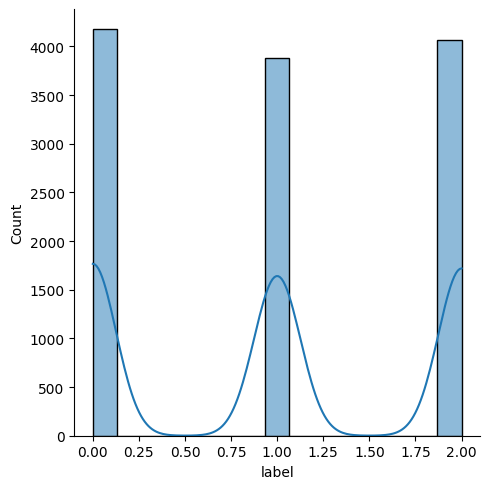

In [7]:
sns.displot(train['label'], kde=True)

In [8]:
train['label'].value_counts()


,count
label,
0,4176
2,4064
1,3880


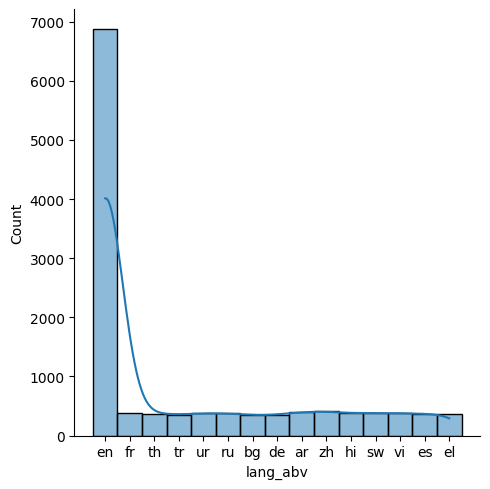

In [9]:
sns.displot(train['lang_abv'], kde=True)


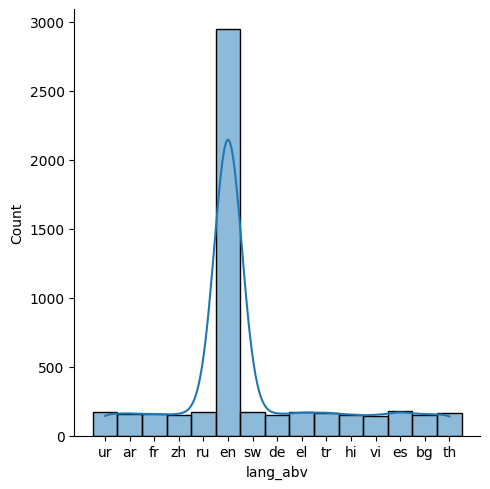

In [10]:
sns.displot(test['lang_abv'], kde=True)


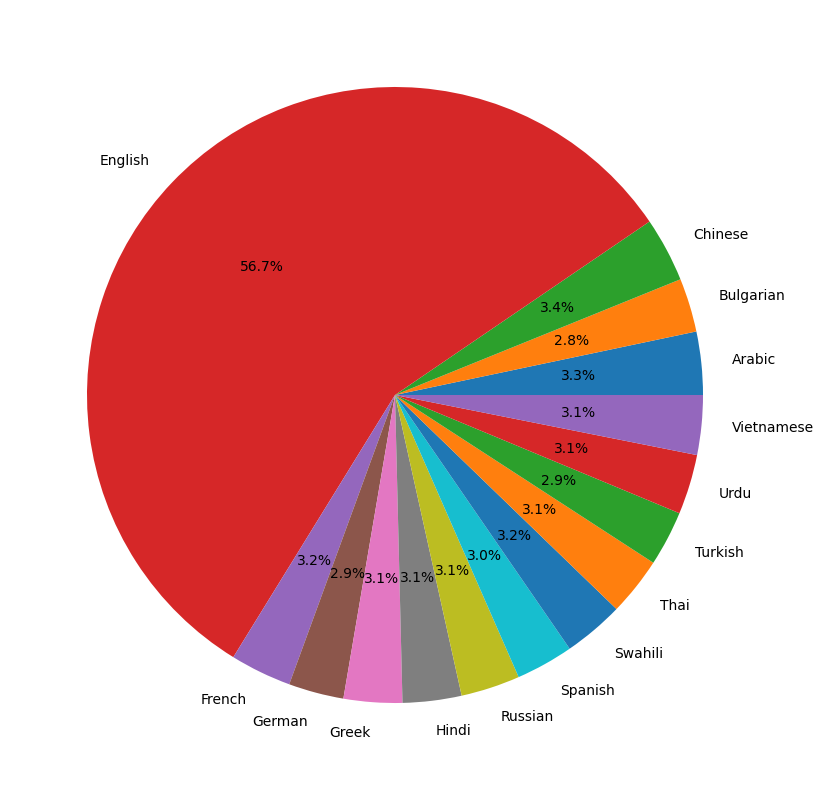

In [11]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

# **Preparing data for model**

In [12]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [13]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [14]:
encode_sentence("Machine learning is fun!")


[16840, 26901, 10124, 41807, 106, 102]

In [15]:
def bert_encode( premises,hypothesis,tokenizer):

    num_examples = len(hypothesis)

    sentence1 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(hypothesis)])
    sentence2 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [16]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)


# **Model definition**

In [17]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, use_safetensors=False)
    input_word_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_type_ids")

    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
with strategy.scope():
    model = build_model()
    model.summary()

tf_model.h5:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions wi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                              

In [18]:
#run this cell before the cell above
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster().cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


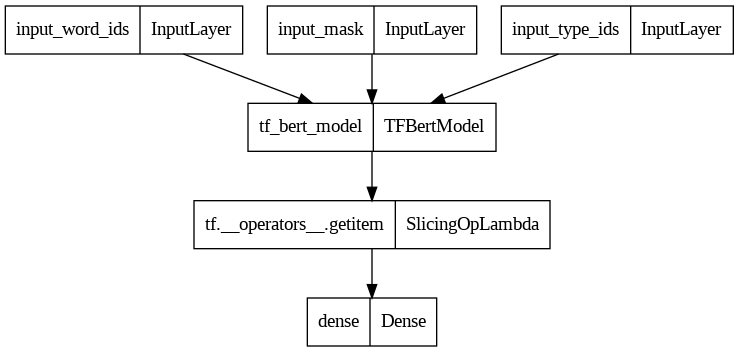

In [20]:
keras.utils.plot_model(model, "statement_classifier.png")


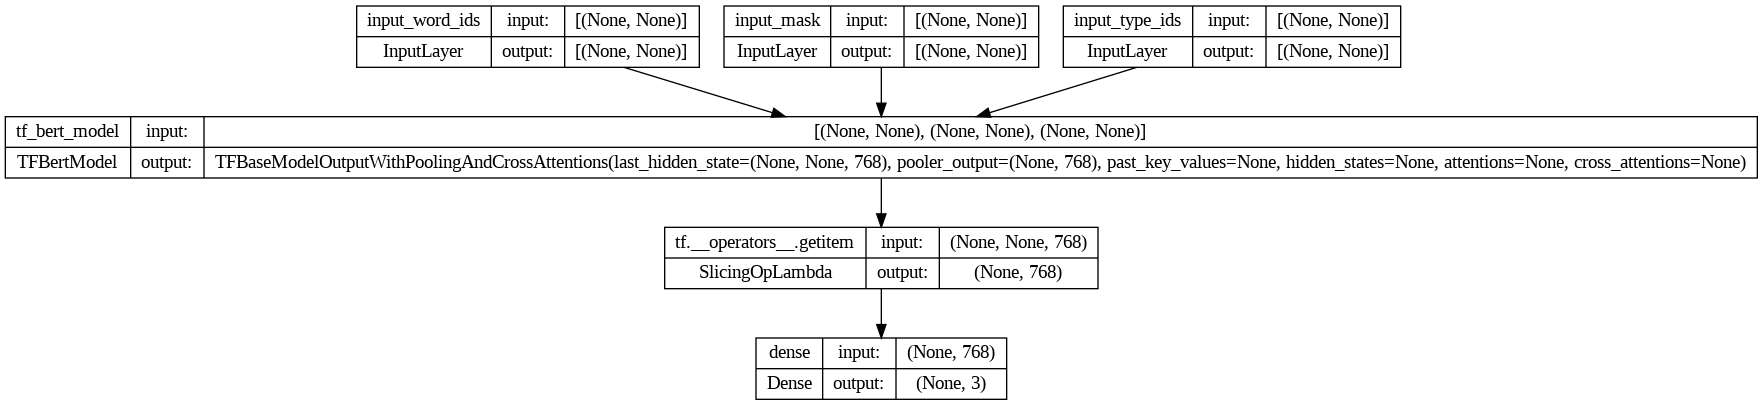

In [21]:
keras.utils.plot_model(model, "statement_classifier_with_shape_info.png", show_shapes=True)


In [22]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [23]:
model.fit(train_input, train.label.values, epochs = 5, verbose = 1, batch_size = 16, validation_split = 0.1)

Epoch 1/5


682/682 [==============================] - 668s 893ms/step - loss: 0.9249 - accuracy: 0.5524 - val_loss: 0.7736 - val_accuracy: 0.6642
Epoch 2/5
682/682 [==============================] - 634s 929ms/step - loss: 0.6906 - accuracy: 0.7053 - val_loss: 0.7591 - val_accuracy: 0.6799
Epoch 3/5
682/682 [==============================] - 632s 927ms/step - loss: 0.4914 - accuracy: 0.8008 - val_loss: 0.9147 - val_accuracy: 0.6848
Epoch 4/5
682/682 [==============================] - 632s 927ms/step - loss: 0.3211 - accuracy: 0.8762 - val_loss: 1.0756 - val_accuracy: 0.6741
Epoch 5/5
682/682 [==============================] - 632s 927ms/step - loss: 0.2161 - accuracy: 0.9202 - val_loss: 1.2007 - val_accuracy: 0.6815


In [24]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)


In [25]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
predictions = np.array(predictions)
predictions = np.ndarray.flatten(predictions)
predictions

163/163 [==============================] - 88s 515ms/step


array([2, 1, 0, ..., 0, 0, 2])

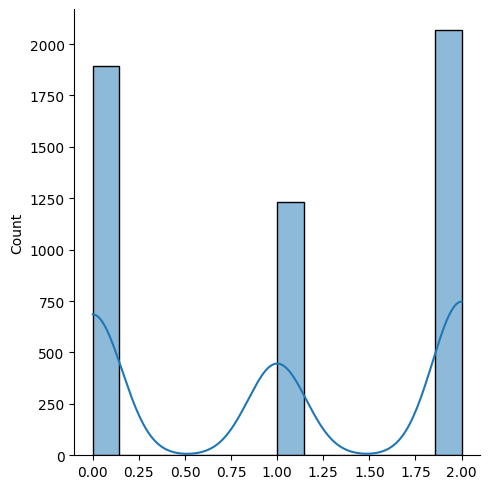

In [26]:
sns.displot(predictions, kde=True)


In [27]:
submission['prediction'] = predictions
submission.to_csv('submission.csv',index=False) # writing data to a CSV file
submission = pd.read_csv("submission.csv")
submission

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2
...,...,...
5190,5f90dd59b0,2
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0
